# Magnetic Force Microscopy

Magnetic force microscopy (MFM) is a powerful technique for examining a sample's stray magnetic field.
The contrast in MFM images originates from the interaction between the magnetic tip of an oscillating cantilever and the stray field.
It has a key role in the imaging of magnetism in thin films and samples with flat surfaces.

The cantilever in a dual pass MFM mode rasters across the same line scan twice, firstly mapping the topography by tapping along the surface at the resonant frequency $\omega_0$ \[[Kazakova 2019](https://aip.scitation.org/doi/10.1063/1.5050712)\].
The second pass lifts the cantilever a set height $z_0$ above the sample surface, which is determined by the first pass. The phase shift $\Delta \phi$ of the resonance is then measured as the probe rasters across the sample.
The tip of an MFM is a complicated magnetic object but usually it can be characterised by an effective magnetic dipole moment and an effective magnetic monopole moment. These moments interact with the stray field produced by the magnetisation of the sample, changing the force on the magnetic tip and hence its resonance. Due to the non-zero size of the tip, the resolution of this technique can be on the scale of tens of nanometres.

MFM is most commonly used to probe the out-of-plane stray magnetic field of a sample but it has the potential to measure different quantities with the tip magnetised in different directions.

## MFM Reference frame

In `mag2exp` the experimental reference for MFM is defined by cantilever oscillating in the $z$ direction.

<img src="Figures/MFM_1.png" width=600>

## The micromagnetic simulation

A micromagnetic simulation can be set up using `Ubermag` to obtain a 3-Dimentional magnetic structure. As MFM is based on the field outside a sample, when simulating MFM we have to create an "airbox". Simply put, this is an area outside of the sample where we wish to perform the MFM measurements, in which we have set the saturation magnetisation equal to zero. It is equivalent to simulating the empty space around the sample. The demagnetisation term must be used as part of the energy equation when defining and relaxing the system as this is the process by which the stray field is calculated.

Here a simulation region is created with a 200 nm edge length and 20 nm in height which contains a magnetic sample.

In [1]:
import discretisedfield as df
import micromagneticmodel as mm
import numpy as np
import oommfc as oc

np.random.seed(1)

region = df.Region(p1=(-100e-9, -100e-9, -20e-9), p2=(100e-9, 100e-9, 0))
mesh = df.Mesh(region=region, cell=(5e-9, 5e-9, 5e-9))

system = mm.System(name="Box2")

system.energy = (
    mm.Exchange(A=1.6e-11)
    + mm.DMI(D=4e-3, crystalclass="T")
    + mm.UniaxialAnisotropy(K=5.1e5, u=(0, 0, 1))
    + mm.Demag()
    + mm.Zeeman(H=(0, 0, 2e5))
)

Ms = 1.1e6


def m_fun(pos):
    return 2 * np.random.rand(3) - 1


# create system with above geometry and initial magnetisation
system.m = df.Field(mesh, nvdim=3, value=m_fun, norm=Ms)

Initial magnetisation:

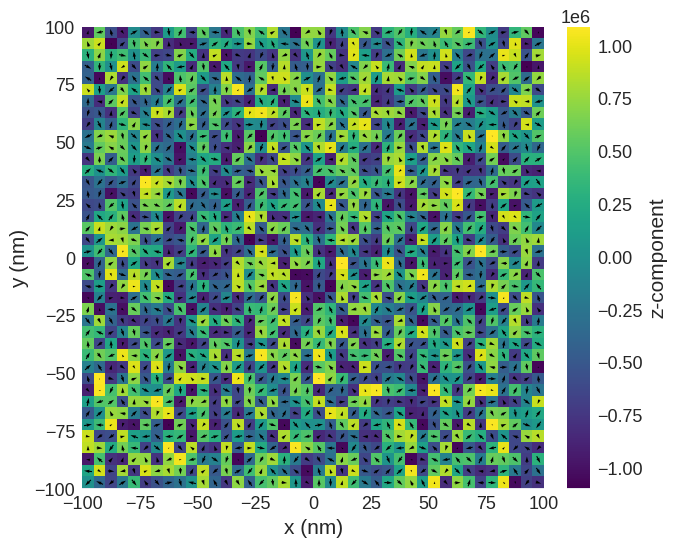

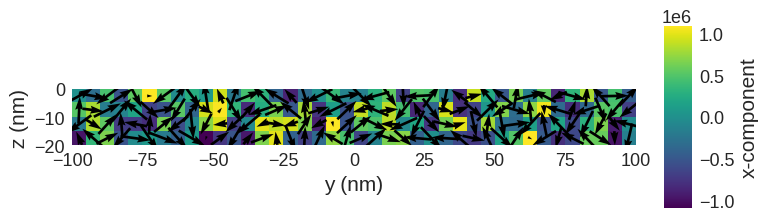

In [2]:
system.m.sel(z=-5e-9).mpl()
system.m.sel("x").mpl()

Relax the system and plot its magnetisation.

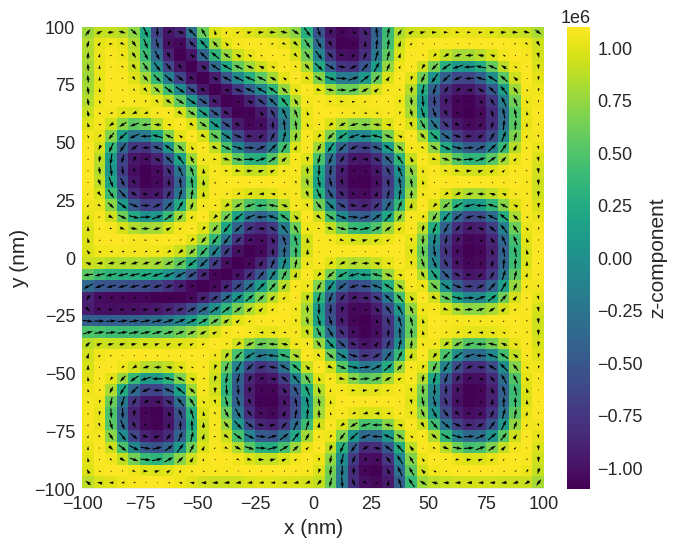

In [3]:
# minimize the energy
md = oc.MinDriver()
md.drive(system, verbose=0)

# Plot relaxed configuration: vectors in z-plane
system.m.sel("z").mpl()

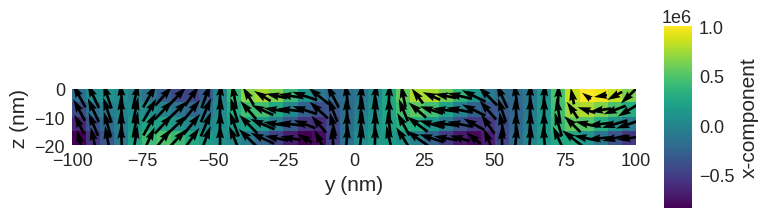

In [4]:
system.m.sel("x").mpl()

`hvplot` can be used to interactively look through the slices of the magnetisation.

In [5]:
system.m.hv(kdims=["x", "y"])

:DynamicMap   [z]
   :Overlay
      .Image.I       :Image   [x,y]   (field)
      .VectorField.I :VectorField   [x,y]   (angle,mag)

We can now create an "airbox" in the region with $z < 0$ nm by padding the field object with zeros in the $z$ direction.

In [6]:
m_field = system.m.pad({"z": (0, 20)}, mode="constant")

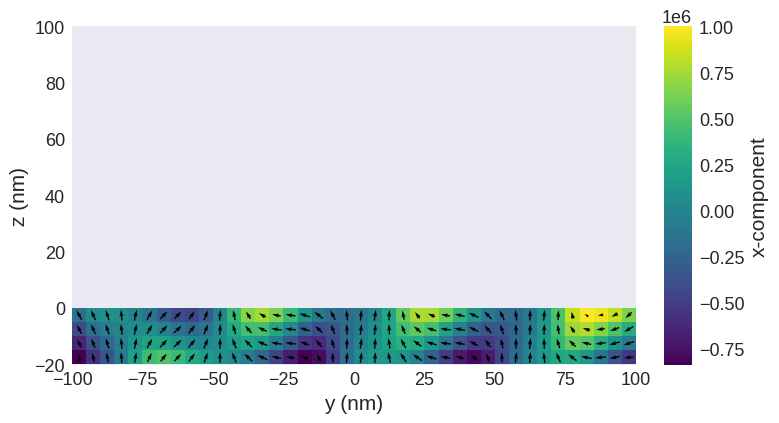

In [7]:
m_field.sel("x").mpl()

Now we have a magnetisation texture we can compute the MFM patterns.

## Computing MFM images

The phase shift of an MFM cantilever can be derived from the equation of simple harmonic motion with an external force and is given by

\begin{equation}
\Delta \phi = \frac{Q\mu_0}{k} \left( q \frac{\partial {\bf H}_{sz}}{\partial z} + {\bf M}_t \cdot \frac{\partial^2{\bf H}_{s}}{\partial z^2} \right),
\end{equation}

where
$Q$ is the quality factor of the cantilever,
$k$ is the spring constant of the cantilever,
$q$ is the magnetic monopole moment of the tip,
${\bf M}_t$ is the magnetic dipole moment of the tip and,
${\bf H}_{sz}$ is the magnetic field due to the sample.


In [8]:
import mag2exp

Each component of the magnetic dipole moment of the tip can be specified to calculate a phase shift. This calculates the phase shift across the whole of the region. However, remember this is only relevant in the "airbox" and not inside the sample!

In [9]:
phase_shift = mag2exp.mfm.phase_shift(m_field, quality=650, k=3, tip_m=(0, 0, 1e-16))

The plane method can be used to easily extract the image obtained at a desired lift off height. For example, at height of 30 nm above the surface. This is why, for simplicity, we defined the top of the sample to be at $z=0$.

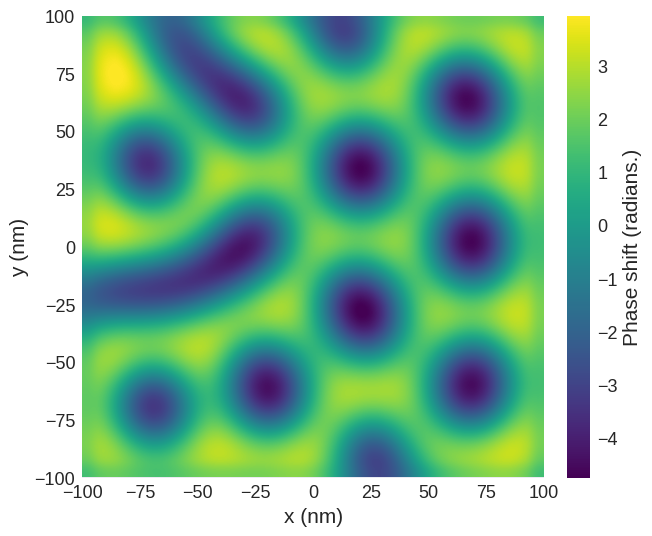

In [10]:
phase_shift.sel(z=30e-9).mpl.scalar(
    interpolation="spline16", colorbar_label=r"Phase shift (radians.)"
)

We can also use `hvplot` to look at the phase shift. Here we just select the region above $z < 0$ nm

In [11]:
sub_region = df.Region(p1=(-100e-9, -100e-9, 7.5e-9), p2=(100e-9, 100e-9, 100e-9))
phase_shift[sub_region].hv(kdims=["x", "y"])

:DynamicMap   [z]
   :Image   [x,y]   (field)

The image below is for with a tip which has an effective monopole moment.

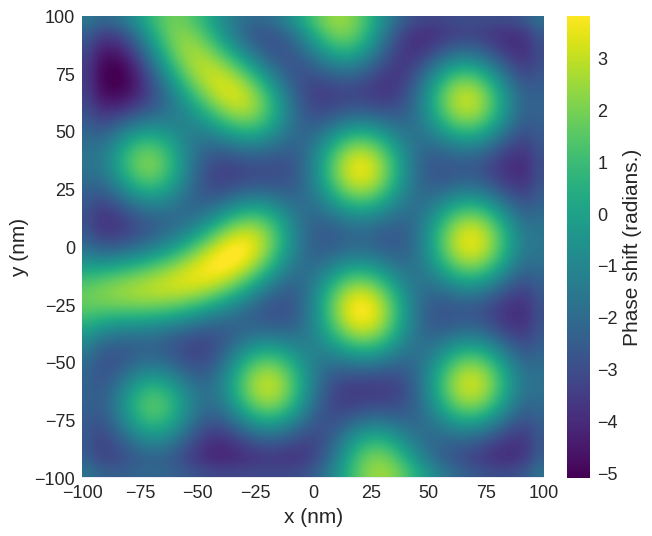

In [12]:
phase_shift_2 = mag2exp.mfm.phase_shift(m_field, quality=650, k=3, tip_q=1e-8)
phase_shift_2.sel(z=30e-9).mpl.scalar(
    interpolation="spline16", colorbar_label=r"Phase shift (radians.)"
)

The image below is for a tip with both a monopole and a dipole.

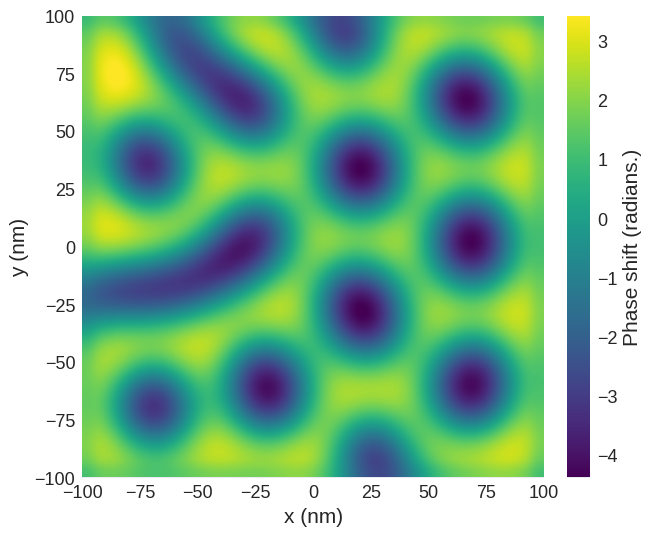

In [13]:
phase_shift_3 = mag2exp.mfm.phase_shift(
    m_field, quality=650, k=3, tip_q=1e-9, tip_m=(0, 0, 1e-16)
)
phase_shift_3.sel(z=30e-9).mpl.scalar(
    interpolation="spline16", colorbar_label=r"Phase shift (radians.)"
)

## The finite size of the tip

Experimentally, the size of the tip limits the resolution of the images. To recreate this the phase shift can be convolved with a Gaussian with a width defined by the full width half maximum.

In [14]:
conv_phase = mag2exp.util.gaussian_filter(phase_shift.sel(z=30e-9), fwhm=(15e-9, 15e-9))

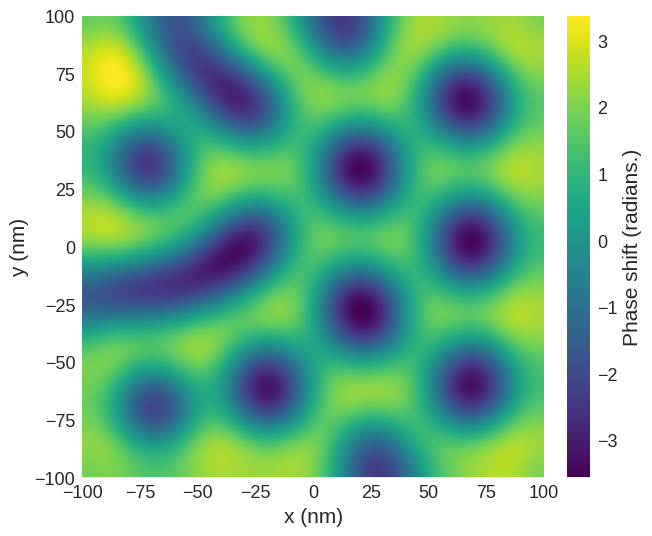

In [15]:
conv_phase.mpl.scalar(
    interpolation="spline16", colorbar_label=r"Phase shift (radians.)"
)

## Quick plots
`mag2exp` has an integrated `quick_plots` functionality which is designed to be easy to use and output figures of the desired quantities directly from the magnetisation texture with all the intermediary calculations performed under the hood. These figures are created with set themes by design, and only take arguments relevant to the quantities being calculated.

`quick_plots.mfm_phase_shift` takes the arguments of `mfm.phase_shift` with an additional parameter `z0` for the height of the plane that will be plotted.

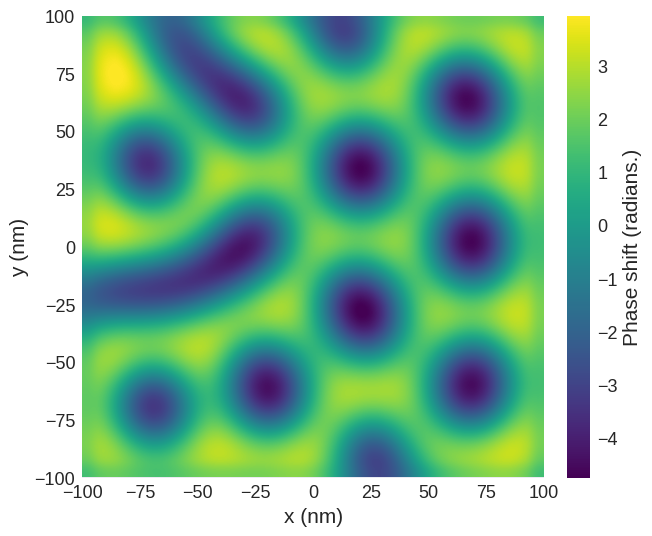

In [16]:
mag2exp.quick_plots.mfm_phase_shift(m_field, z0=30e-9, tip_m=(0, 0, 1e-16))

It is possible to look at how the phase shift varies as a function of lift of height across the sample. Due to the phase shift spanning different orders of magnitude in both positive and negative regions we can use `BoundaryNorm` from `matplotlib` to define our colour bar.

In [17]:
import matplotlib.colors as colors

sub_phase = phase_shift[sub_region]

boundaries = sorted(sub_phase.array.flat)[:: len(sub_phase.array.flat) // 100][:-1] + [
    np.max(sub_phase.array.flat)
]


@df.interact(x=system.m.mesh.slider("x"))
def plot(x):
    conv_mag2exp = sub_phase.sel(x=x)
    conv_mag2exp.mpl.scalar(
        norm=colors.BoundaryNorm(boundaries=boundaries, ncolors=256)
    )

interactive(children=(SelectionSlider(description='x (nm)', index=20, options=((-97.5, -9.749999999999999e-08)…